In this program, our task is to find that in parameter transfer and selective layer optimization of QAOA, by optimizing which single layer gives the best result as compares to any other single layer optimized. We choose a range of noise parameters for testing. We have fixed the total circuit depth of QAOA.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize

from qiskit.quantum_info import Kraus
from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,  # for T1 error
    phase_damping_error,  # for T2 error
    depolarizing_error,  # for Gate error
    pauli_error,
)

from qiskit_aer import AerSimulator
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


Donor Graph which will be fully optimized using QAOA of depth p and then it's optimized parameters will be trasferred into acceptor graph as initial parameters

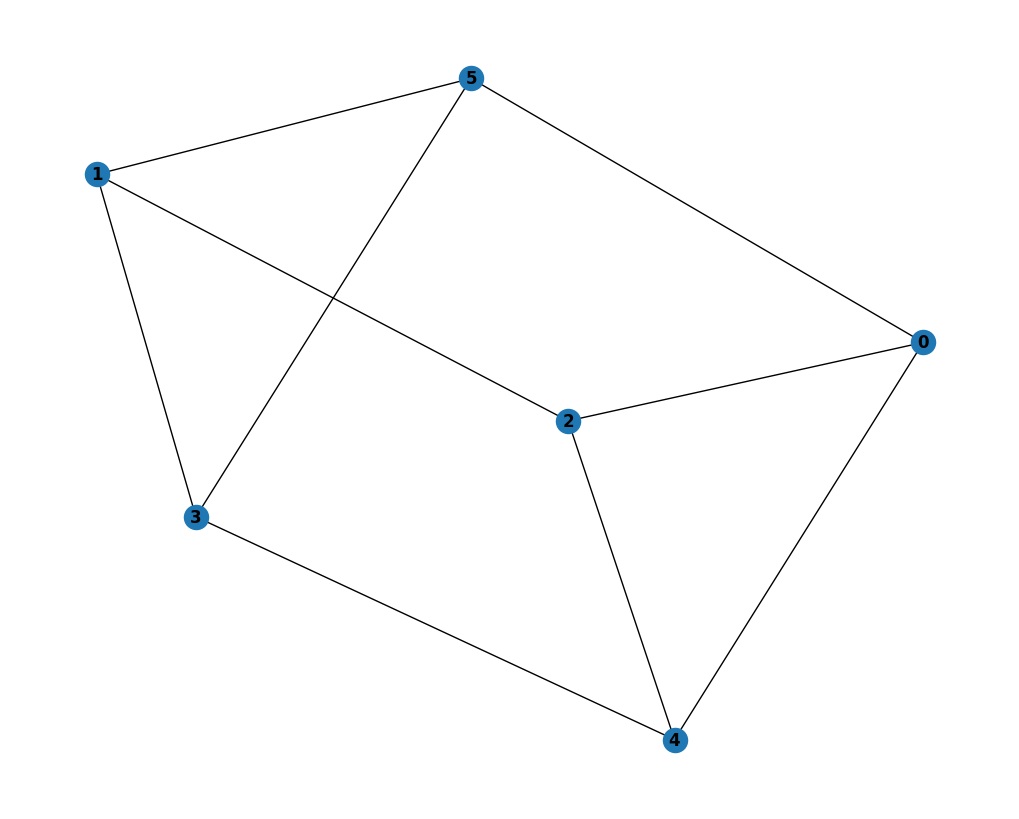

In [55]:
# make sure dxn is even for d-regular graph.
n1 = 6  # number of vertices
d = 3  #  d-regular graph
p = 5  # QAOA layers

plt.figure(figsize=(10,8))
# udR (unweghted d-regular) graph
G1 = nx.random_regular_graph(d ,n1)
for (u,v) in G1.edges():
    G1[u][v]['weight'] = 1.0

edges1 = G1.edges()
nx.draw(G1, with_labels=True, font_weight='bold')

# weight matrix
w1 = np.zeros([n1,n1])
for (u,v) in G1.edges():
    w1[u][v] = G1[u][v]['weight']
    w1[v][u] = G1[u][v]['weight']
#print(w1)
#plt.savefig('cost_function_landspace.pdf', dpi=300, bbox_inches='tight')
#plt.close
#plt.show()


Exact Maxcut value for donor graph using classical brute force method

In [56]:
# classical solution
sol1 = 0
for b in range(2**n1):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n1)))]
    Cut_value1 = 0
    for i in range(n1):
        for j in range(n1):
            Cut_value1 += w1[i][j]*x1[i]*(1-x1[j])
    if sol1 < Cut_value1:
        sol1 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol1}")

Classical solution: 7.0


converting classical maxcut problem into cost Hamiltonian

In [57]:
prob=Maxcut(w1)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian1, offset1 = qubo.to_ising()
print('offset:', offset1)
print(cost_hamiltonian1)

Problem name: Max-cut

Maximize
  -2*x_0*x_2 - 2*x_0*x_4 - 2*x_0*x_5 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_1*x_5
  - 2*x_2*x_4 - 2*x_3*x_4 - 2*x_3*x_5 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5

Problem name: Max-cut

Minimize
  2*x_0*x_2 + 2*x_0*x_4 + 2*x_0*x_5 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_1*x_5
  + 2*x_2*x_4 + 2*x_3*x_4 + 2*x_3*x_5 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4
  - 3*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5

offset: -4.5
SparsePauliOp(['IIIZIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIZZI', 'IIZIZI', 'ZIIIZI', 'IZIZII', 'IZZIII', 'ZIZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


Function to calculate expectation value of Hamiltonian w.r.t. the quantum circuit. 

In [58]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

Initializing parameters for donor graph's QAOA and preparing circuit

In [59]:
# Initializing the parameters for our quanutum circuit 
# using Trotterized Quantum Annealing Initialization method.
init_params = np.zeros(2*p)
tt = 0.75
for i in range(0, p, 1):
    init_params[i] = (1.0-i/p)*tt
    init_params[i+p] = (i/p)*tt

# Preparing circuit
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian1, reps=p)
circuit.measure_all()

Running the circuit in ideal case for donor graph to get 2p optimized parameters to transfer

In [60]:
#--------------------------------------------------------------------------------
# Ideal Case
sim_ideal = AerSimulator()
pm5 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
candidate_circuit5 = pm5.run(circuit)

with Session(backend=sim_ideal) as session:  
    estimator = Estimator(mode=session)  
    estimator.options.default_shots = 100000  
    result5 = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit5, cost_hamiltonian1, estimator),
        method="COBYLA",
        tol=1e-3,
    )
ideal_cost = result5.fun+offset1  # adding offset to get the true expectation value (energy)
print('ideal_cost: ', ideal_cost)
print('ideal cost accuracy:',-ideal_cost/sol1)


ideal_cost:  -6.796252037479626
ideal cost accuracy: 0.9708931482113751


Transferrring optimized parameters

In [61]:
tra_params = result5.x
print(tra_params)

[1.81172433 0.83543866 1.4730264  1.34038225 1.42959475 0.2936359
 0.08303947 0.56504191 0.42048069 1.45068524]


Acceptor Graph which has more nodes than donor graph. It's QAOA will be selectively optimized after using the optimized parameters of donor graph as acceptor graph.

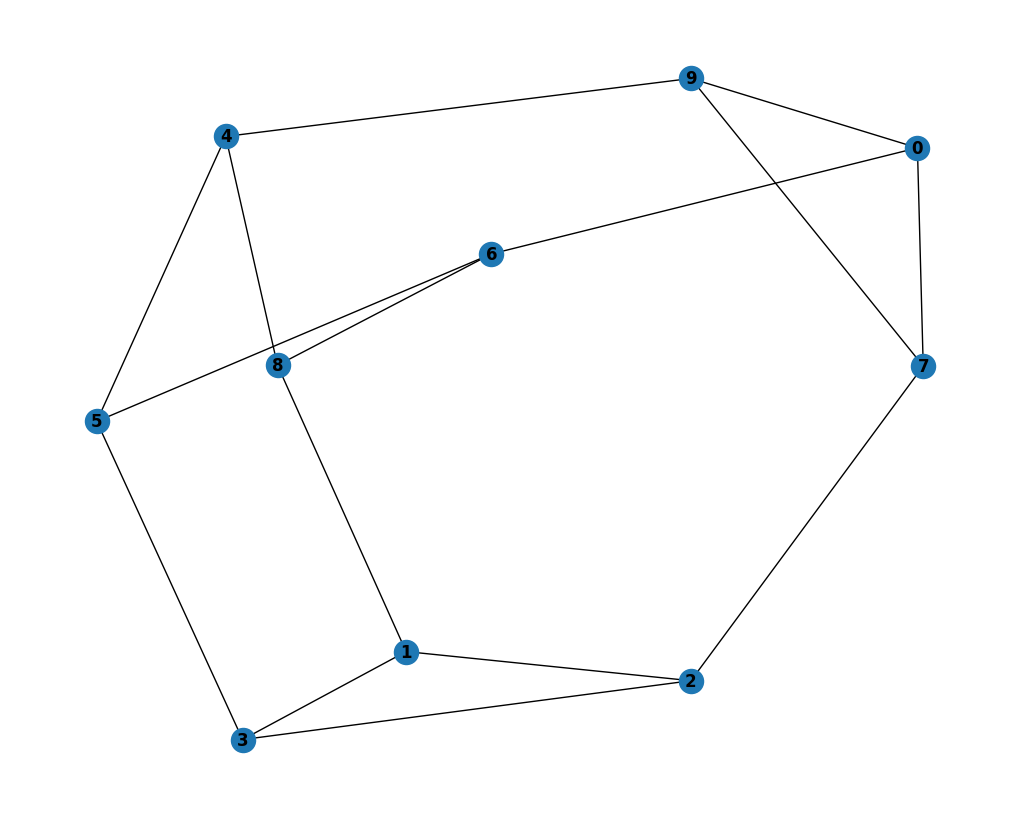

In [62]:
# make sure dxn is even for d-regular graph.
n2 = 10  # number of vertices

plt.figure(figsize=(10,8))
# udR (unweghted d-regular) graph
G2 = nx.random_regular_graph(d ,n2)
for (u,v) in G2.edges():
    G2[u][v]['weight'] = 1.0

edges = G2.edges()
nx.draw(G2, with_labels=True, font_weight='bold')

# weight matrix
w2 = np.zeros([n2,n2])
for (u,v) in G2.edges():
    w2[u][v] = G2[u][v]['weight']
    w2[v][u] = G2[u][v]['weight']
#print(w2)
#plt.savefig('cost_function_landspace.pdf', dpi=300, bbox_inches='tight')
#plt.close
#plt.show()


True Maxcut value of acceptor graph

In [63]:
# classical solution
sol2 = 0
for b in range(2**n2):
    x1 = [int(t) for t in reversed(list(bin(b)[2:].zfill(n2)))]
    Cut_value1 = 0
    for i in range(n2):
        for j in range(n2):
            Cut_value1 += w2[i][j]*x1[i]*(1-x1[j])
    if sol2 < Cut_value1:
        sol2 = Cut_value1
        xlist1 = x1

print(f"Classical solution: {sol2}")

Classical solution: 13.0


Converting Classical acceptor graph Maxcut problem into Hamiltonian

In [64]:
prob=Maxcut(w2)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian2, offset2 = qubo.to_ising()
print('offset: ',offset2)
print(cost_hamiltonian2)

Problem name: Max-cut

Maximize
  -2*x_0*x_6 - 2*x_0*x_7 - 2*x_0*x_9 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_1*x_8
  - 2*x_2*x_3 - 2*x_2*x_7 - 2*x_3*x_5 - 2*x_4*x_5 - 2*x_4*x_8 - 2*x_4*x_9
  - 2*x_5*x_6 - 2*x_6*x_8 - 2*x_7*x_9 + 3*x_0 + 3*x_1 + 3*x_2 + 3*x_3 + 3*x_4
  + 3*x_5 + 3*x_6 + 3*x_7 + 3*x_8 + 3*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

Problem name: Max-cut

Minimize
  2*x_0*x_6 + 2*x_0*x_7 + 2*x_0*x_9 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_1*x_8
  + 2*x_2*x_3 + 2*x_2*x_7 + 2*x_3*x_5 + 2*x_4*x_5 + 2*x_4*x_8 + 2*x_4*x_9
  + 2*x_5*x_6 + 2*x_6*x_8 + 2*x_7*x_9 - 3*x_0 - 3*x_1 - 3*x_2 - 3*x_3 - 3*x_4
  - 3*x_5 - 3*x_6 - 3*x_7 - 3*x_8 - 3*x_9

Subject to
  No constraints

  Binary variables (10)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9

offset:  -7.5
SparsePauliOp(['IIIZIIIIIZ', 'IIZIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IZIIIIIIZI', 'IIIIIIZZII', 'IIZIIIIZII', 'IIIIZIZIII', 'IIIIZZIIII', 'IZIIIZIIII', 'ZIIIIZIIII', 'IIIZZII

Function which gives expectation value of cost Hamiltonian by varying parameters of only selectively optimizable layer.

In [65]:
def cost_func_estimator_selective(params, ansatz, hamiltonian, estimator, m):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    sel_par = tra_params.copy()
    sel_par[m] = params[0]
    sel_par[p+m] = params[1]
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, sel_par)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

range of noise parameter

In [66]:
err = np.linspace(1e-4,1e-2,10)

In [67]:
phf = np.zeros([p, len(err)])
bif = np.zeros([p, len(err)])
amd = np.zeros([p, len(err)])
phd = np.zeros([p, len(err)])
dep = np.zeros([p, len(err)])
all = np.zeros([p, len(err)])

taking a fixed noise parameter value

In [68]:
error = err[0]
print(error)

0.0001


Different noises for fixed noise parameter

In [ ]:
# 1-qubit noises
err_phf = pauli_error([("Z", error), ("I", 1 - error)])
err_bif = pauli_error([("X", error), ("I", 1 - error)])
err_amd = amplitude_damping_error(error)
err_phd = phase_damping_error(error)
err_dep_1q = depolarizing_error(error, num_qubits=1)


In [ ]:
# 2-qubit noises
err_phf_2q = err_phf.tensor(err_phf)
err_bif_2q = err_bif.tensor(err_bif)
err_amd_2q = err_amd.tensor(err_amd)
err_phd_2q = err_phd.tensor(err_phd)
err_dep_2q = depolarizing_error(error, num_qubits=2)

Combining all 1-qubit noise togather and 2-qubit noise togather

In [71]:
err_all_1q = err_phf.compose(err_bif).compose(err_amd).compose(err_phd).compose(err_dep_1q)
err_all_2q = err_phf.compose(err_bif_2q).compose(err_amd_2q).compose(err_phd_2q).compose(err_dep_2q)

Preparing noise model for these fixed noises

In [72]:
# Noise Model
noise_all = NoiseModel()
noise_all.add_all_qubit_quantum_error(err_all_1q, ['u1', 'u2', 'u3'])  # 1-qubit error qate specifications
noise_all.add_all_qubit_quantum_error(err_all_2q, ['cx'])  # 2-qubit error gate specifications
print(noise_all)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u3', 'u1', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']


preparing noisy circuit

In [73]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian2, reps=p)
circuit.measure_all()# Creating the circuit by using Noisy gates as defined by the Noise Model
sim_all = AerSimulator(noise_model = noise_all)
pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
candidate_circuit2 = pm1.run(circuit)


Optimizing all layers of this noisy circuit

In [75]:
#--------------------------------------------------------------------------------
# Noise full optimization
with Session(backend=sim_all) as session:  
    estimator = Estimator(mode=session)  
    estimator.options.default_shots = 100000  
    result2 = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit2, cost_hamiltonian2, estimator),
        method="COBYLA",
        tol=1e-3,
    )
full_noisy_cost = result2.fun+offset2  # adding offset to get the true expectation value (energy)
print('full_noisy_cost: ', full_noisy_cost)
print('full noisy cost accuracy:',-full_noisy_cost/sol2)


full_noisy_cost:  -11.101688983110169
full noisy cost accuracy: 0.8539760756238591


Optimizing only single layer of noisy circuit

In [76]:
print('Selective optimization solution quality in noisy case')

for jj in range(0, p, 1):
    with Session(backend=sim_all) as session:  
        estimator = Estimator(mode=session)  
        estimator.options.default_shots = 100000  
        opt_par = [tra_params[jj], tra_params[p+jj]]
        result4 = minimize(
            cost_func_estimator_selective,
            opt_par,
            args=(candidate_circuit2, cost_hamiltonian2, estimator, jj),
            method="COBYLA",
            tol=1e-3,
        )
    all_cost = result4.fun+offset2
    print(f'Layer {jj}:',-all_cost/sol2)
    

Selective optimization solution quality in noisy case
Layer 0: 0.8635859795248201
Layer 1: 0.863814438778689
Layer 2: 0.8647151990018561
Layer 3: 0.8655698058404031
Layer 4: 0.8684159312253031


Taking range of noise and then optimizing only songle layer one by one

In [77]:

for kk in range(0, len(err), 1):
    err_phf = pauli_error([("Z", err[kk]), ("I", 1 - err[kk])])
    err_bif = pauli_error([("X", err[kk]), ("I", 1 - err[kk])])
    err_amd = amplitude_damping_error(err[kk])
    err_phd = phase_damping_error(err[kk])
    err_dep_1q = depolarizing_error(err[kk], num_qubits=1)
    err_dep_2q = depolarizing_error(err[kk], num_qubits=2)

    err_phf_2q = err_phf.tensor(err_phf)
    err_bif_2q = err_bif.tensor(err_bif)
    err_amd_2q = err_amd.tensor(err_amd)
    err_phd_2q = err_phd.tensor(err_phd)

    err_all_1q = err_phf.compose(err_bif).compose(err_amd).compose(err_phd).compose(err_dep_1q)
    err_all_2q = err_phf.compose(err_bif_2q).compose(err_amd_2q).compose(err_phd_2q).compose(err_dep_2q)

    # Noise Model
    noise_all = NoiseModel()
    noise_all.add_all_qubit_quantum_error(err_all_1q, ['u1', 'u2', 'u3'])  # 1-qubit err[kk] qate specifications
    noise_all.add_all_qubit_quantum_error(err_all_2q, ['cx'])  # 2-qubit err[kk] gate specifications

    sim_all = AerSimulator(noise_model = noise_all)
    pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
    candidate_circuit2 = pm1.run(circuit)

    for jj in range(0, p, 1):
        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            opt_par = [tra_params[jj], tra_params[p+jj]]
            result4 = minimize(
                cost_func_estimator_selective,
                tra_params,
                args=(candidate_circuit2, cost_hamiltonian2, estimator, jj),
                method="COBYLA",
                tol=1e-3,
            )
        all_cost = result4.fun+offset2

        all[jj][kk] = all_cost

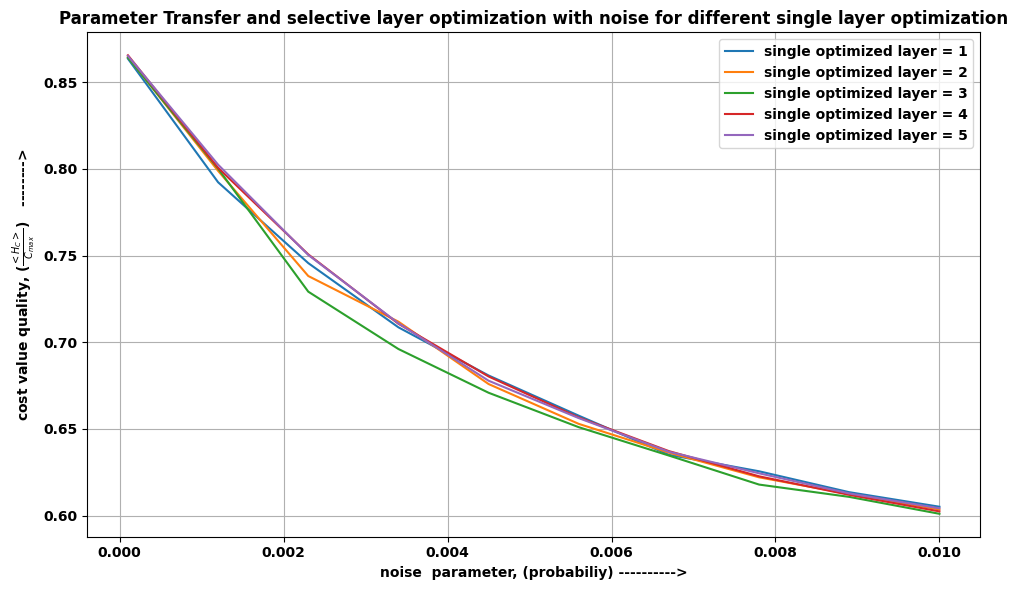

In [87]:
from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

plt.figure(figsize=(10,6))
for i in range(0, p, 1):
    plt.plot(err, -all[i]/sol2, label=f'single optimized layer = {i+1}')
plt.xlabel('noise  parameter, (probabiliy) ---------->', fontweight='bold')
plt.ylabel('cost value quality, ($\\frac{<H_C>}{C_{max}}$)   -------->', fontweight='bold')
plt.grid()
plt.title('Parameter Transfer and selective layer optimization with noise for different single layer optimization', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('noisy selective optimization.pdf', dpi=300)
plt.show()
